# Movie Investing / ROI

In [286]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t

## Data Sets Import

In [1]:
crew_movie = pd.read_csv('data-6.tsv', sep = '\t')
titles = pd.read_csv('data-8.tsv', sep = '\t')
names = pd.read_csv('data-9.tsv', sep = '\t')
bo = pd.read_csv('boxoffice.csv')
mm = pd.read_csv('movies_metadata.csv')

/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

In [2]:
drop_list = ['self', 'production_designer', 'archive_footage', 'archive_sound']
crew_movie = crew_movie[~crew_movie.category.isin(drop_list)]
crew_movie.drop(columns = ['characters', 'job'], inplace = True)

In [11]:
titles.drop(columns=['endYear', 'originalTitle'], inplace = True)
titles = titles[titles['startYear'] != '\\N']
titles['startYear'] = titles['startYear'].astype(int)
titles = titles[(titles.titleType == 'movie') & (titles.isAdult == 0) & (titles.startYear > 1997)]
titles.drop(columns=['titleType','isAdult'], inplace = True)

In [ ]:
names.drop(columns = ['knownForTitles','primaryProfession'], inplace = True)
names[(names.deathYear == '\\N') & (names.birthYear != '\\N')]

In [ ]:
bo = bo[bo.year > 1997]
bo.drop(columns = ['rank', 'studio'], inplace = True)

In [86]:
for i,element in enumerate(mm.budget):
    try:
        int(element)
    except:
        mm.at[i, 'budget'] = 0

In [84]:
mm['budget'] = mm.budget.astype(int)
mm = mm[(mm.adult == 'False') & (mm.budget > 0)]
mm_columns_to_keep = ['budget','imdb_id', 'original_language', 'original_title', 'revenue']
mm = mm[mm_columns_to_keep]

## Data Merging

In [256]:
titles_merged_tmp = pd.merge(titles, bo, how='inner', left_on = 'primaryTitle', right_on = 'title')
titles_merged = pd.merge(titles_merged_tmp, mm, how='inner', left_on = 'tconst', right_on = 'imdb_id')
titles_merged [['genre1', 'genre2', 'genre3']] = titles_merged.genres.str.split(',', expand=True)

titles_merged.drop(columns = ['primaryTitle', 'imdb_id','original_title'], inplace = True)

titles_merged.loc[titles_merged.budget == 0,'budget'] = np.nan
titles_merged.loc[titles_merged.lifetime_gross == 0,'lifetime_gross'] = np.nan
titles_merged.loc[titles_merged.revenue == 0,'revenue'] = np.nan
titles_merged['profit'] = titles_merged.revenue - titles_merged.budget
titles_merged['outus_gross'] = titles_merged.revenue - titles_merged.lifetime_gross

titles_merged

,tconst,startYear,runtimeMinutes,genres,title,lifetime_gross,year,budget,original_language,revenue,genre1,genre2,genre3,profit,outus_gross
0,tt0113026,2000,86,"Musical,Romance",The Fantasticks,49666.0,2000,10000000.0,en,NaN,Musical,Romance,None,NaN,NaN
1,tt0118589,2001,104,"Drama,Music,Romance",Glitter,4274407.0,2001,22000000.0,en,5271666.0,Drama,Music,Romance,-16728334.0,997259.0
2,tt0118636,1998,111,"Crime,Drama,Thriller",Apt Pupil,8863193.0,1998,14000000.0,en,NaN,Crime,Drama,Thriller,NaN,NaN
3,tt0449467,2006,143,Drama,Babel,34302837.0,2006,25000000.0,en,135330182.0,Drama,None,None,110330182.0,101027345.0
4,tt0118665,1999,97,"Comedy,Crime,Family",Baby Geniuses,27250736.0,1999,12000000.0,en,36450736.0,Comedy,Crime,Family,24450736.0,9200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3563,tt6003368,2017,91,"Comedy,Family",Diary of a Wimpy Kid: The Long Haul,20738724.0,2017,22000000.0,en,40120144.0,Comedy,Family,None,18120144.0,19381420.0
3564,tt6083388,2017,128,"Action,History",God of War,53496.0,2017,25000000.0,zh,NaN,Action,History,None,NaN,NaN
3565,tt6265828,2017,92,"Drama,Fantasy,Romance",A Ghost Story,1596371.0,2017,100000.0,en,15584255.0,Drama,Fantasy,Romance,15484255.0,13987884.0
3566,tt6322922,2017,98,Documentary,An Inconvenient Sequel: Truth to Power,3496795.0,2017,1000000.0,en,NaN,Documentary,None,None,NaN,NaN


In [259]:
all_data_tmp = pd.merge(titles_merged, crew_movie, how='inner')
all_data = pd.merge (all_data_tmp, names,how='inner')
all_data = all_data[all_data.deathYear == '\\N']
all_data.drop(columns = ['tconst','startYear','genres','ordering','nconst','deathYear'], inplace = True)
all_data.columns = ['runtime', 'title', 'us_gross', 'year', 'budget','original_language', 'int_gross', 'genre1', 'genre2', 'genre3','profit','outus_gross', 'category', 'name', 'birthyear']

## Analysis by Genre

In [262]:
genres_values = pd.unique(titles_merged[['genre1', 'genre2', 'genre3']].values.ravel('K'))
genres_values = genres_values[genres_values != None]
genres_df = {genre:titles_merged[(titles_merged.genre1 == genre)|(titles_merged.genre2 == genre)| (titles_merged.genre3 == genre)] for genre in genres_values}

In [445]:
genre_intervals = {}

column_names = ['genre', 'samples_us', 'samples_non_us', 'samples_profit', \
                'us_gross_mean', 'non_us_gross_mean', 'profit_mean', \
               'us_gross_min', 'us_gross_max', 'non_us_gross_min', 'non_us_gross_max', \
               'profit_min', 'profit_max']

money_genre = pd.DataFrame(columns = column_names)

for genre, tmp in genres_df.items():
  
  samples_pr = tmp.profit.count()
  samples_us = tmp.lifetime_gross.count()
  samples_nonus = tmp.outus_gross.count()
  
    
  mean_pr = tmp.profit.mean()
  mean_us_gross = tmp.lifetime_gross.mean()
  mean_out_gross = tmp.outus_gross.mean()
  pr_int = t.interval(0.95,tmp.profit.count()-1, tmp.profit.mean(), tmp.profit.std()/np.sqrt(tmp.profit.count()-1))
  us_gr_int = t.interval(0.95,tmp.lifetime_gross.count()-1, tmp.lifetime_gross.mean(), tmp.lifetime_gross.std()/np.sqrt(tmp.lifetime_gross.count()-1))                       
  outus_gr_int = t.interval(0.95,tmp.outus_gross.count()-1, tmp.outus_gross.mean(), tmp.outus_gross.std()/np.sqrt(tmp.outus_gross.count()-1))

  money_genre = money_genre.append(pd.DataFrame([[genre,samples_us, \
                samples_nonus, samples_pr, mean_us_gross, mean_out_gross,mean_pr, \
                us_gr_int[0], us_gr_int[1], outus_gr_int[0], outus_gr_int[1],\
                pr_int[0], pr_int[1]]], columns = column_names))

money_genre.sort_values(by = 'us_gross_mean',inplace = True, ascending = False)

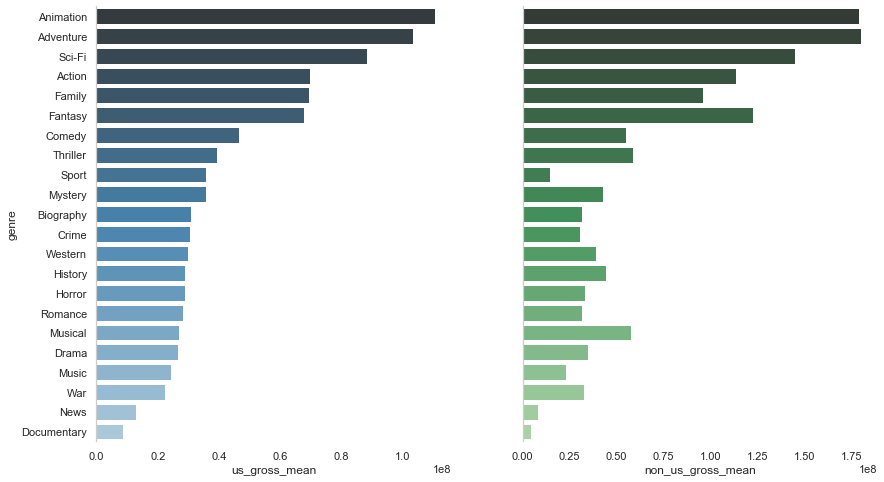

In [573]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig, axs = plt.subplots(1,2, figsize = (14,8), sharey = True)

axs[0] = sns.barplot(x='us_gross_mean', y='genre', data = money_genre, palette="Blues_d", ax = axs[0])
axs[1] = sns.barplot(x='non_us_gross_mean', y='genre', data = money_genre, palette="Greens_d", ax = axs[1])
axs[0].grid = False

frame1 = plt.gca()
#frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)

for i, a in enumerate(axs):
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.spines["bottom"].set_visible(False)

In [585]:
cm1 = np.arange(0, 0.9, 0.0001) [0:len(money_genre)][::-1]
cm2 = np.arange(0, 0.9, 0.0001) [0:len(money_genre)] [::-1]
cm3 = np.arange(0, 0.9, 0.03) [0:len(money_genre)][::-1]

cm4 = np.arange(0.8, 1, 0.001) [0:len(money_genre)][::-1]
cm5 = np.arange(0, 0.9, 0.01) [0:len(money_genre)] [::-1]
cm6 = np.arange(0, 0.9, 0.01) [0:len(money_genre)][::-1]

cma = tuple([(cm1[i], cm2[i],cm3[i]) for i in range(len(money_genre))])
cma

cmb = tuple([(cm4[i], cm5[i],cm6[i]) for i in range(len(money_genre))])
cmb

((0.8210000000000001, 0.21, 0.21),
 (0.8200000000000001, 0.2, 0.2),
 (0.8190000000000001, 0.19, 0.19),
 (0.8180000000000001, 0.18, 0.18),
 (0.8170000000000001, 0.17, 0.17),
 (0.8160000000000001, 0.16, 0.16),
 (0.8150000000000001, 0.15, 0.15),
 (0.8140000000000001, 0.14, 0.14),
 (0.8130000000000001, 0.13, 0.13),
 (0.812, 0.12, 0.12),
 (0.811, 0.11, 0.11),
 (0.81, 0.1, 0.1),
 (0.809, 0.09, 0.09),
 (0.808, 0.08, 0.08),
 (0.807, 0.07, 0.07),
 (0.806, 0.06, 0.06),
 (0.805, 0.05, 0.05),
 (0.804, 0.04, 0.04),
 (0.803, 0.03, 0.03),
 (0.802, 0.02, 0.02),
 (0.801, 0.01, 0.01),
 (0.8, 0.0, 0.0))

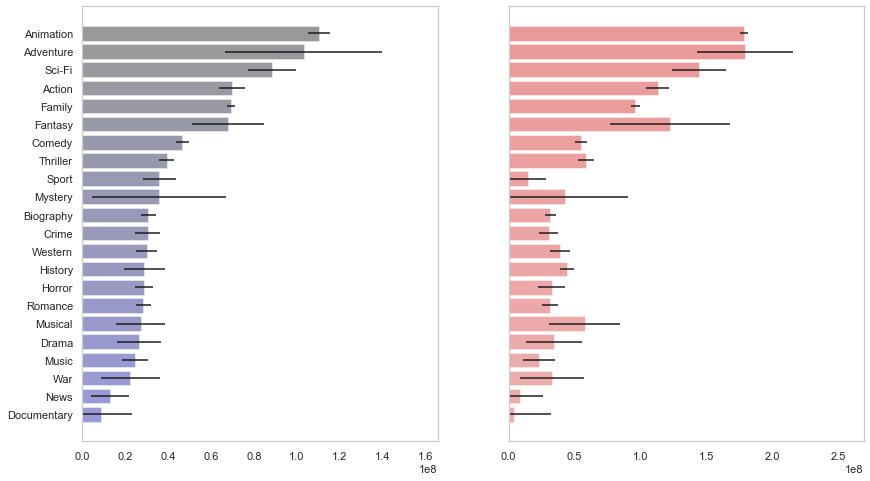

In [586]:
fig, axs = plt.subplots(1,2, figsize = (14,8), sharey = True)

y_pos = np.arange(len(money_genre))
x_r = list(money_genre.us_gross_mean - money_genre.us_gross_max)
axs[0].grid(False)
axs[0].set_xlim(0,max(money_genre.us_gross_mean)*1.5)
axs[0].barh(y_pos,money_genre.us_gross_mean[::-1], xerr=x_r, alpha=0.4, color =cma)
axs[0].set_yticks(range(len(money_genre)))
axs[0].set_yticklabels(money_genre.genre[::-1])

x_r = list(money_genre.non_us_gross_mean - money_genre.non_us_gross_max)
axs[1].grid(False)
axs[1].set_xlim(0,max(money_genre.non_us_gross_mean)*1.5)
axs[1].barh(y_pos,money_genre.non_us_gross_mean[::-1], xerr=x_r, alpha=0.4, color=cmb)

plt.show()

## Analysis by Professional Category

In [133]:
pro_cat = all_data.category.unique()
pro_cat_values = {cat : all_data.loc[all_data['category'] == cat].name.unique() for cat in pro_cat}

In [409]:
column_names = ['category', 'name', 'samples_us', 'samples_non_us', 'samples_profit', 'us_gross_mean', 'non_us_gross_mean', 'profit_mean', \
               'us_gross_min', 'us_gross_max', 'non_us_gross_min', 'non_us_gross_max', \
               'profit_min', 'profit_max']

money_stats = pd.DataFrame(columns = column_names)

for cat, members in pro_cat_values.items():
 for member in members:
  tmp = all_data.loc[(all_data.name == member) & (all_data.category == cat)][['profit', 'us_gross', 'outus_gross']]
  
  samples_pr = tmp.profit.count()
  samples_us = tmp.us_gross.count()
  samples_nonus = tmp.outus_gross.count()
    
  mean_pr = tmp.profit.mean()
  mean_us_gross = tmp.us_gross.mean()
  mean_out_gross = tmp.outus_gross.mean()
  pr_int = t.interval(0.95,tmp.profit.count()-1, tmp.profit.mean(), tmp.profit.std()/np.sqrt(tmp.profit.count()-1))
  us_gr_int = t.interval(0.95,tmp.us_gross.count()-1, tmp.us_gross.mean(), tmp.us_gross.std()/np.sqrt(tmp.us_gross.count()-1))                       
  outus_gr_int = t.interval(0.95,tmp.outus_gross.count()-1, tmp.outus_gross.mean(), tmp.outus_gross.std()/np.sqrt(tmp.outus_gross.count()-1))

  money_stats = money_stats.append(pd.DataFrame([[cat, member, samples_us, \
                samples_nonus, samples_pr, mean_us_gross, mean_out_gross,mean_pr, \
                us_gr_int[0], us_gr_int[1], outus_gr_int[0], outus_gr_int[1],\
                pr_int[0], pr_int[1]]], columns = column_names))

money_stats

/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


,category,name,samples_us,samples_non_us,samples_profit,us_gross_mean,non_us_gross_mean,profit_mean,us_gross_min,us_gross_max,non_us_gross_min,non_us_gross_max,profit_min,profit_max
0,actor,Joel Grey,1,0,0,4.966600e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,actor,Joey McIntyre,1,0,0,4.966600e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,actor,Eric Benét,1,1,1,4.274407e+06,9.972590e+05,-1.672833e+07,NaN,NaN,NaN,NaN,NaN,NaN
0,actor,Max Beesley,1,1,1,4.274407e+06,9.972590e+05,-1.672833e+07,NaN,NaN,NaN,NaN,NaN,NaN
0,actor,Ian McKellen,14,13,13,1.996253e+08,4.224909e+08,4.979441e+08,1.245289e+08,2.747218e+08,2.401841e+08,6.047978e+08,2.714654e+08,7.244228e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,editor,Roger Nygard,1,1,1,2.157119e+07,0.000000e+00,1.257119e+07,NaN,NaN,NaN,NaN,NaN,NaN
0,editor,Gregory Perler,1,1,1,2.703954e+08,3.620483e+08,5.574437e+08,NaN,NaN,NaN,NaN,NaN,NaN
0,editor,Per Sandholt,1,0,0,4.352660e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,editor,Matthew Hannam,1,0,0,1.398512e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [412]:
def cat_plot(cat, min_samp):
    df_cat = money_stats[(money_stats.category == cat) & (money_stats.samples_profit>min_samp)]
    df_cat.sort_values(by = 'profit_mean',inplace = True, ascending = False)
    df_cat = df_cat[0:20]

    fig, axs = plt.subplots(1,2, figsize = (14,8), sharey = True)

    plt.suptitle(cat)
    sns.barplot(x='us_gross_mean', y='name', data = df_cat, palette="Blues_d", ax = axs[0])
    sns.barplot(x='non_us_gross_mean', y='name', data = df_cat, palette="Greens_d", ax = axs[1])

/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


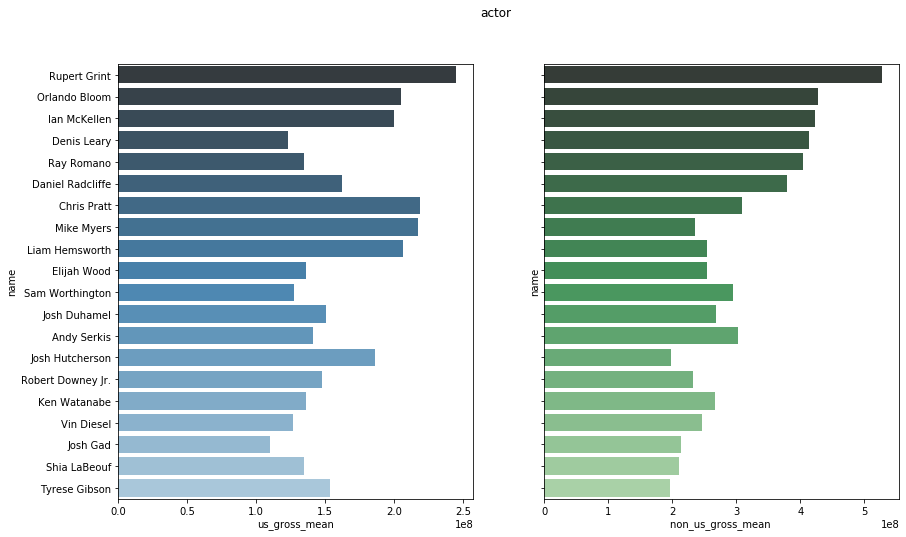

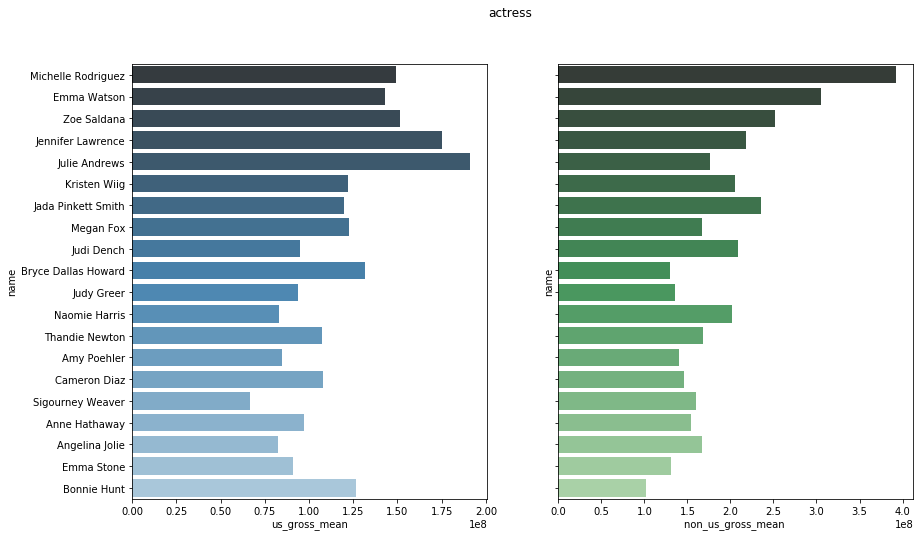

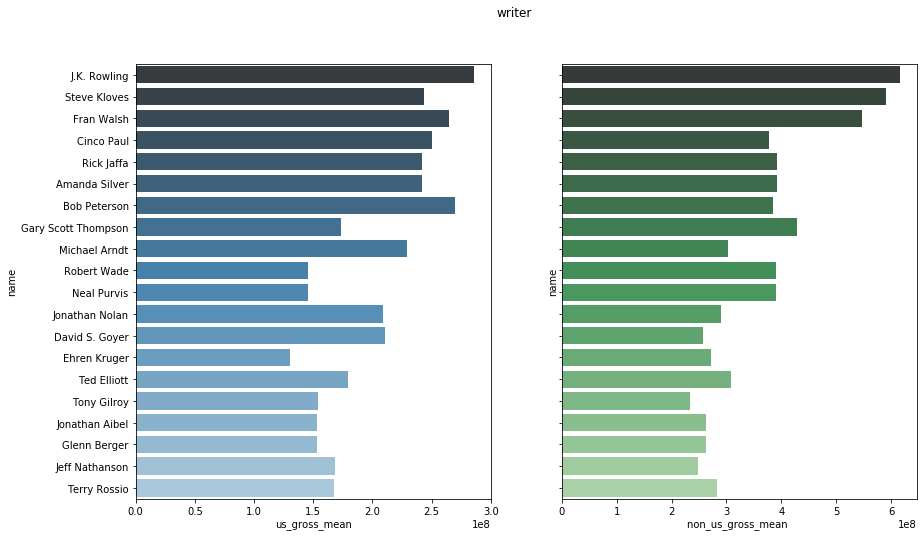

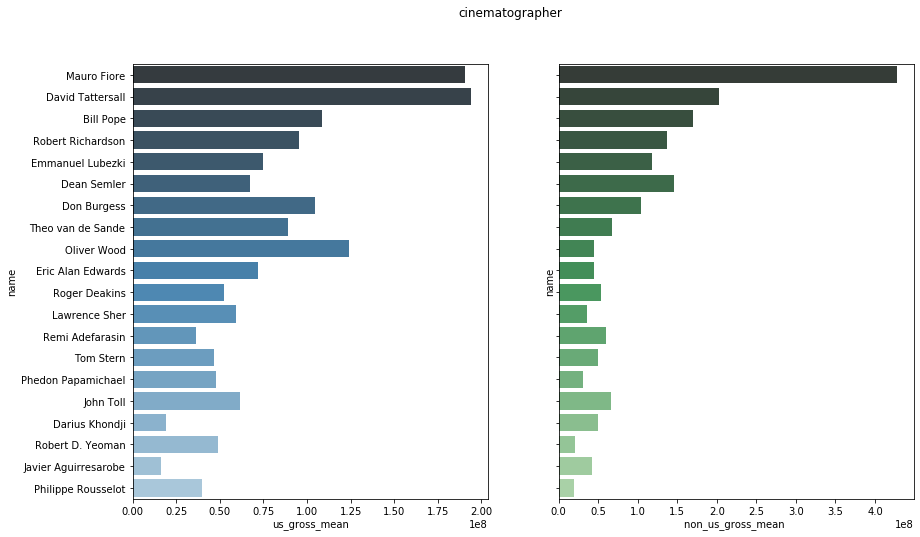

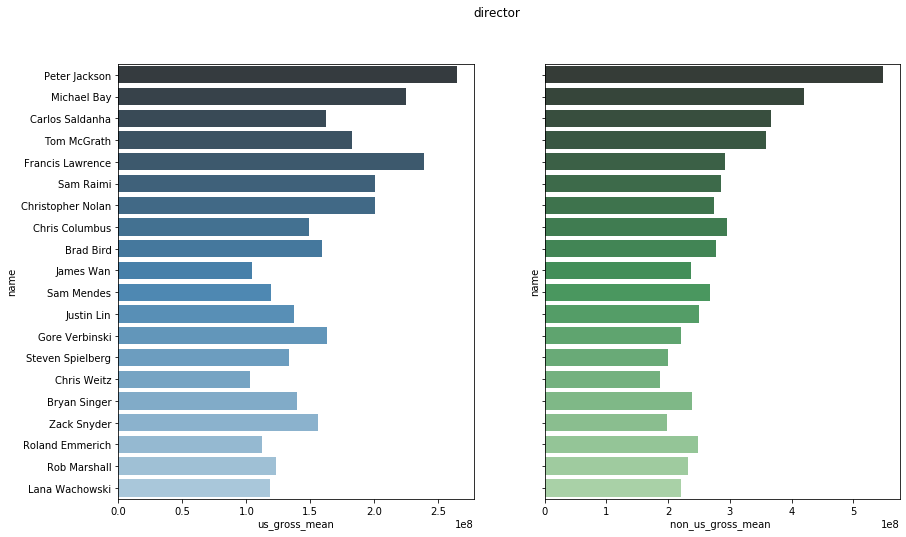

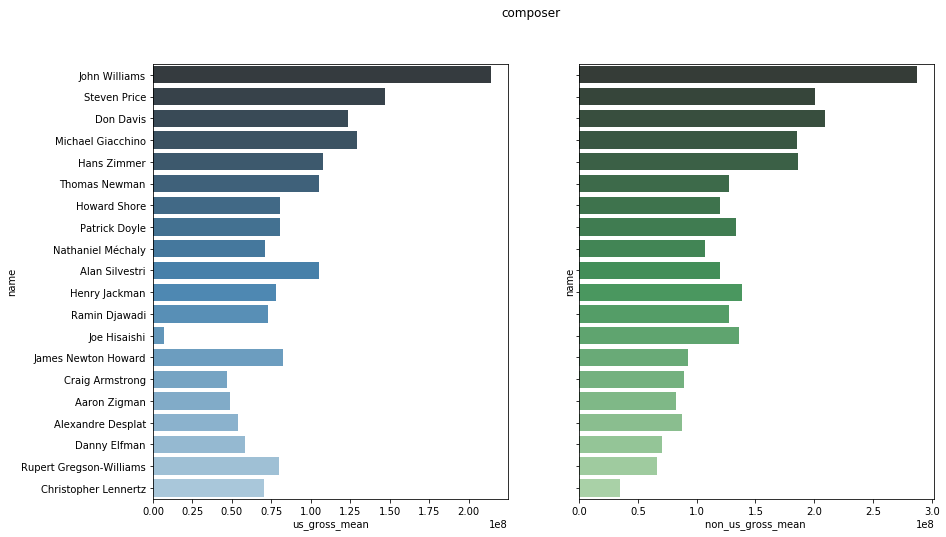

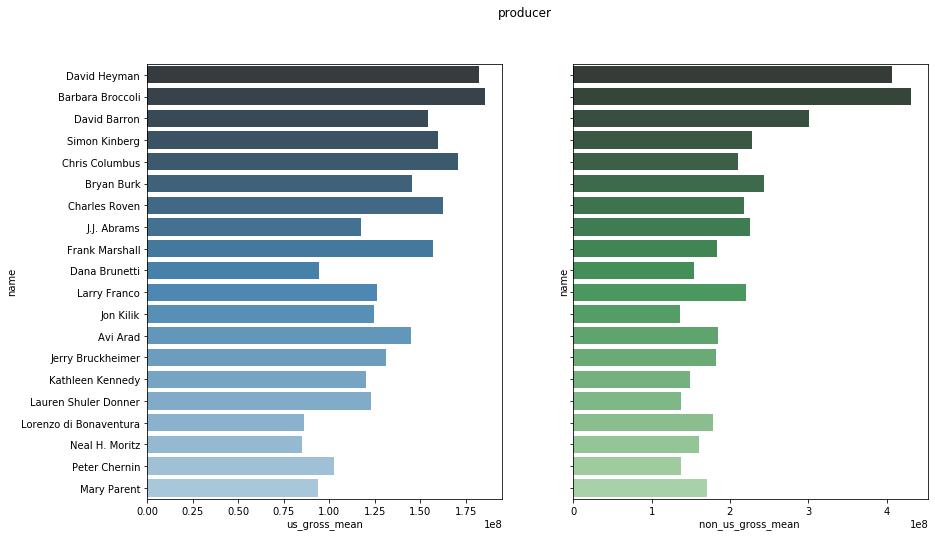

In [397]:
for cat in pro_cat[:-1]: cat_plot(cat,4)

## Analysis by runtime

## Budget Limitation

In [416]:
max_budget = 10

In [417]:
genre_intervals = {}

column_names = ['genre', 'samples_us', 'samples_non_us', 'samples_profit', \
                'us_gross_mean', 'non_us_gross_mean', 'profit_mean', \
               'us_gross_min', 'us_gross_max', 'non_us_gross_min', 'non_us_gross_max', \
               'profit_min', 'profit_max']

money_genre = pd.DataFrame(columns = column_names)

for genre, tmp in genres_df.items():
  
  tmp = tmp[tmp.budget < max_budget * 1000000]
  samples_pr = tmp.profit.count()
  samples_us = tmp.lifetime_gross.count()
  samples_nonus = tmp.outus_gross.count()
  
  mean_pr = tmp.profit.mean()
  mean_us_gross = tmp.lifetime_gross.mean()
  mean_out_gross = tmp.outus_gross.mean()
  pr_int = t.interval(0.95,tmp.profit.count()-1, tmp.profit.mean(), tmp.profit.std()/np.sqrt(tmp.profit.count()-1))
  us_gr_int = t.interval(0.95,tmp.lifetime_gross.count()-1, tmp.lifetime_gross.mean(), tmp.lifetime_gross.std()/np.sqrt(tmp.lifetime_gross.count()-1))                       
  outus_gr_int = t.interval(0.95,tmp.outus_gross.count()-1, tmp.outus_gross.mean(), tmp.outus_gross.std()/np.sqrt(tmp.outus_gross.count()-1))

  money_genre = money_genre.append(pd.DataFrame([[genre,samples_us, \
                samples_nonus, samples_pr, mean_us_gross, mean_out_gross,mean_pr, \
                us_gr_int[0], us_gr_int[1], outus_gr_int[0], outus_gr_int[1],\
                pr_int[0], pr_int[1]]], columns = column_names))

money_genre.sort_values(by = 'us_gross_mean',inplace = True, ascending = False)

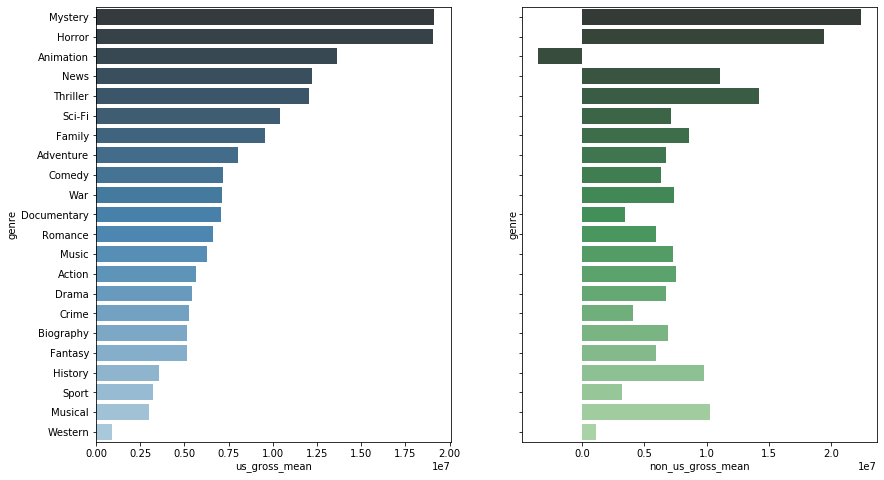

In [418]:
fig, axs = plt.subplots(1,2, figsize = (14,8), sharey = True)

axs[0] = sns.barplot(x='us_gross_mean', y='genre', data = money_genre, palette="Blues_d", ax = axs[0])
axs[1] = sns.barplot(x='non_us_gross_mean', y='genre', data = money_genre, palette="Greens_d", ax = axs[1])

In [419]:
column_names = ['category', 'name', 'samples_us', 'samples_non_us', 'samples_profit', 'us_gross_mean', 'non_us_gross_mean', 'profit_mean', \
               'us_gross_min', 'us_gross_max', 'non_us_gross_min', 'non_us_gross_max', \
               'profit_min', 'profit_max']

money_stats = pd.DataFrame(columns = column_names)

for cat, members in pro_cat_values.items():
 for member in members:
  tmp = all_data.loc[(all_data.name == member) & (all_data.category == cat) & (all_data.budget < max_budget * 1000000)][['profit', 'us_gross', 'outus_gross']]
  
  samples_pr = tmp.profit.count()
  samples_us = tmp.us_gross.count()
  samples_nonus = tmp.outus_gross.count()
    
  mean_pr = tmp.profit.mean()
  mean_us_gross = tmp.us_gross.mean()
  mean_out_gross = tmp.outus_gross.mean()
  pr_int = t.interval(0.95,tmp.profit.count()-1, tmp.profit.mean(), tmp.profit.std()/np.sqrt(tmp.profit.count()-1))
  us_gr_int = t.interval(0.95,tmp.us_gross.count()-1, tmp.us_gross.mean(), tmp.us_gross.std()/np.sqrt(tmp.us_gross.count()-1))                       
  outus_gr_int = t.interval(0.95,tmp.outus_gross.count()-1, tmp.outus_gross.mean(), tmp.outus_gross.std()/np.sqrt(tmp.outus_gross.count()-1))

  money_stats = money_stats.append(pd.DataFrame([[cat, member, samples_us, \
                samples_nonus, samples_pr, mean_us_gross, mean_out_gross,mean_pr, \
                us_gr_int[0], us_gr_int[1], outus_gr_int[0], outus_gr_int[1],\
                pr_int[0], pr_int[1]]], columns = column_names))

money_stats

/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


,category,name,samples_us,samples_non_us,samples_profit,us_gross_mean,non_us_gross_mean,profit_mean,us_gross_min,us_gross_max,non_us_gross_min,non_us_gross_max,profit_min,profit_max
0,actor,Joel Grey,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,actor,Joey McIntyre,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,actor,Eric Benét,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,actor,Max Beesley,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,actor,Ian McKellen,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,editor,Roger Nygard,1,1,1,21571189.0,0.0,12571189.0,NaN,NaN,NaN,NaN,NaN,NaN
0,editor,Gregory Perler,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,editor,Per Sandholt,1,0,0,435266.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,editor,Matthew Hannam,1,0,0,13985117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


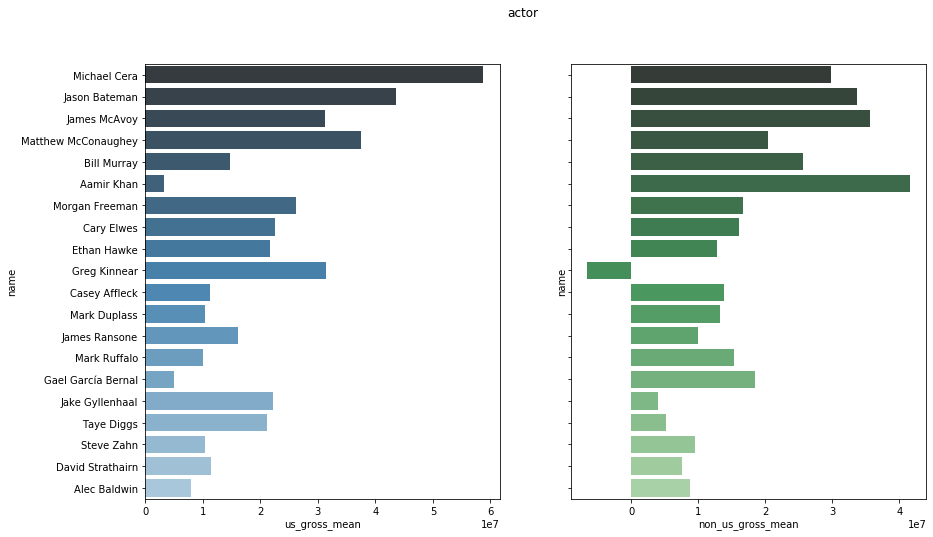

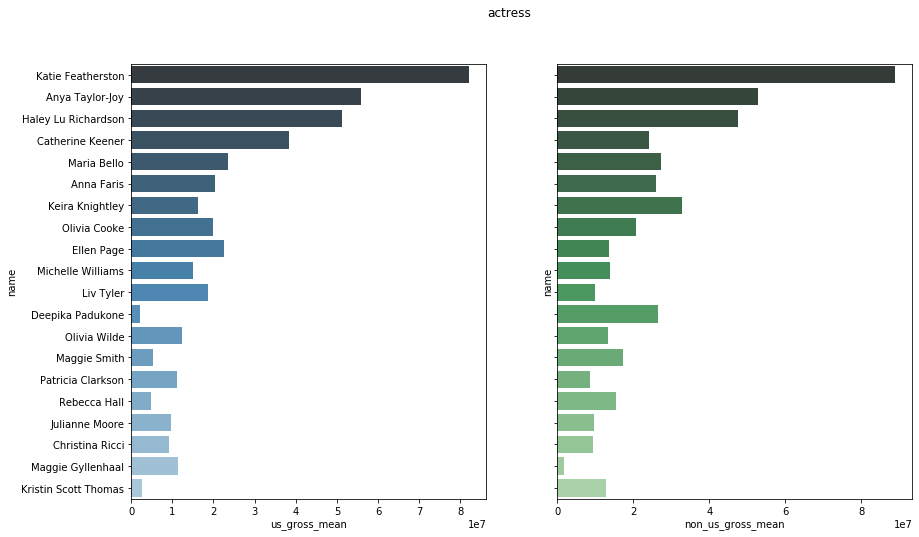

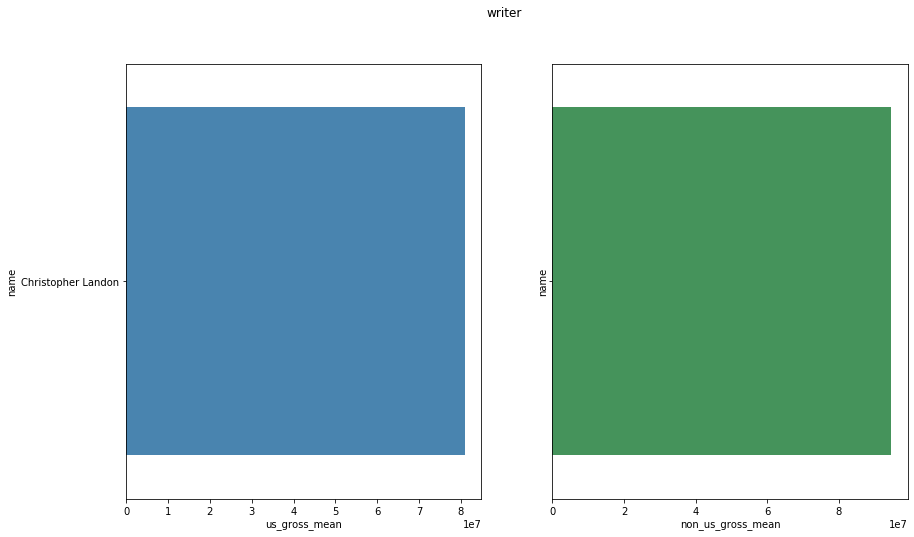

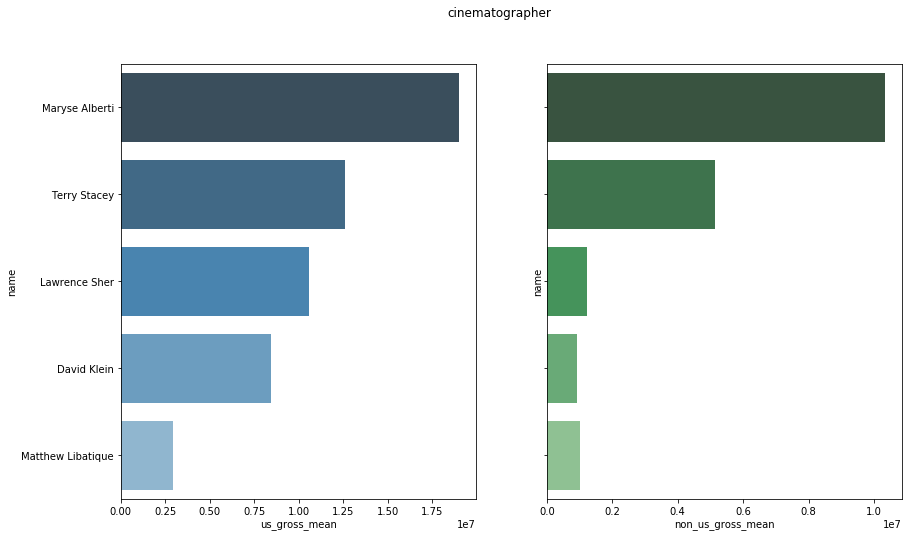

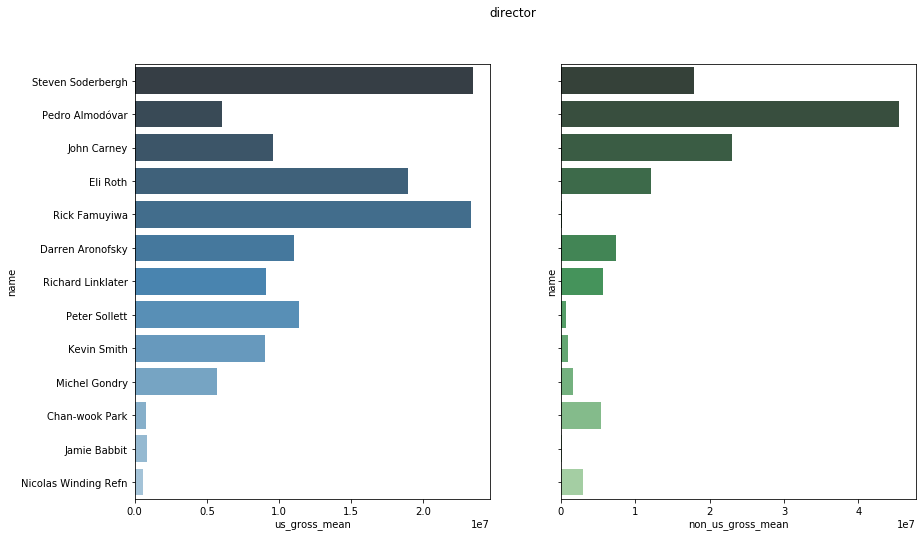

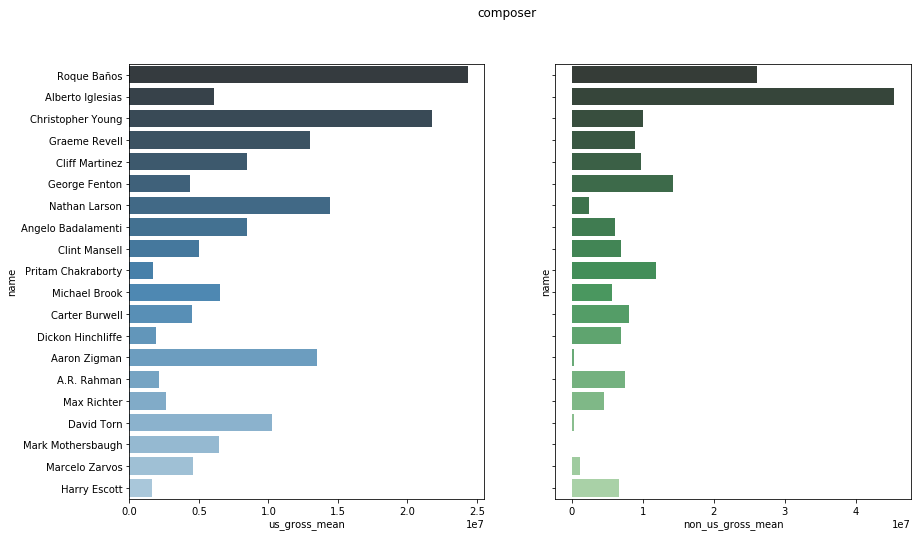

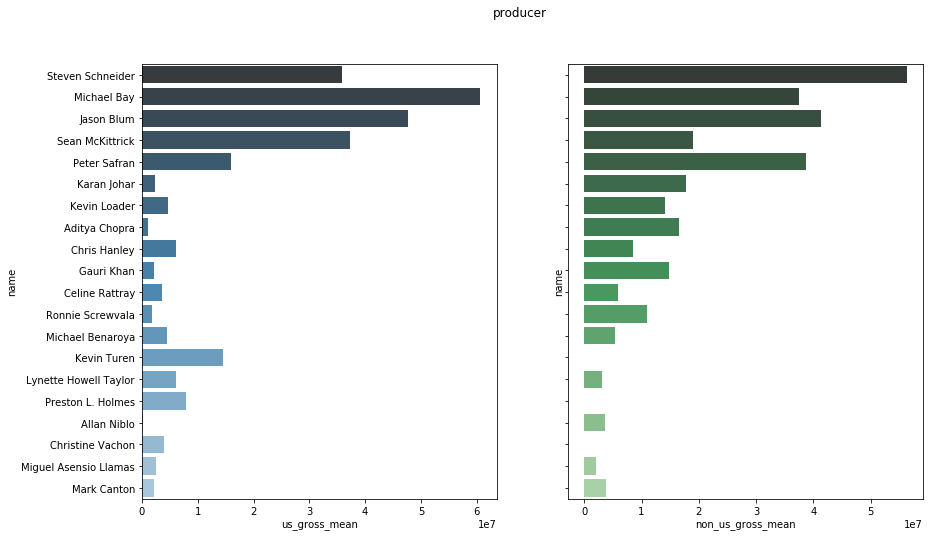

In [420]:
for cat in pro_cat[:-1]: cat_plot(cat,2)

In [602]:
titles_run = titles_merged[titles_merged.runtimeMinutes != '\\N'] 
titles_run['runtimeMinutes'] = titles_run.runtimeMinutes.astype(int)
titles.dtypes
#pd.qcut(titles_merged.runtimeMinutes, q = [30,60,90,120,150,180])

/Users/joaoeira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


tconst            object
primaryTitle      object
startYear          int64
runtimeMinutes    object
genres            object
dtype: object